### TASK3: Do a bit of research on similar problems such as named entity recognition, find a dataset, train a model, and report your results.

The chosen data is taken from https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv
    
And the data set is for name entity recodnition, the two columns selected are 'Word' and 'POS' <br>
The model was trained on SGD optimizer with lr of 0.01 and a momentum of 0.9 and a loss function of NNLLoss()
And the results are as follows:

Top-1 Accuracy: 0.917979162196314 Top-2 Accuracy: 0.9770784159454498 <br>
CPU times: user 55min 8s, sys: 1min, total: 56min 8s <br>
Wall time: 10min 17s

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import torch
import glob
import os
import unicodedata
import string
import numpy as np
import torch.optim as optim
import pandas as pd
from IPython.display import clear_output

In [2]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

Configured device:  cuda:1


### 1. Load data

https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv

In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

df = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape') 
df = df.fillna(method="ffill")
df = df.drop(['Tag'], axis =1)
df = df.drop(['Sentence #'], axis =1)
# words = df['Word']
# tags = df['POS']

#### 1.1 Build the cat_words dictionary, a list of tags per word and a list of all words

In [6]:
cat_words = {}
all_tags = []
all_words = []
tags = list(set(df["POS"].values))

for i in tags:
    cat_words[i] = []

for i in range(len(df)):
    cat_words[df['POS'].iloc[i]].append(df['Word'].iloc[i])
    all_tags.append(df['POS'].iloc[i])
    all_words.append(df['Word'].iloc[i])

In [7]:
for i in tags:
    print(f'{i}:{len(cat_words[i])}')
    
print(len(all_words))
print(len(all_tags))

NNP:131426
``:3728
VBN:32328
PDT:147
RB:20252
WDT:3698
MD:6973
CC:23716
RBS:296
PRP:13318
EX:663
VBG:19125
NN:145807
RBR:1055
UH:24
JJR:2967
VBD:39379
.:47831
TO:23061
::795
NNPS:2521
WP:2542
,:32757
JJS:3034
WRB:2184
IN:120996
VBP:16158
WP$:99
DT:98454
;:214
VBZ:24960
FW:1
CD:24695
LRB:678
RRB:679
PRP$:8655
POS:11257
JJ:78412
$:1149
VB:24211
RP:2490
NNS:75840
1048575
1048575


#### All words

In [10]:
print(np.unique(df['Word']))
print(len(np.unique(df['Word'])))

['!' '"' '#' ... '\x96' '\x97' '°C']
35178


#### All tags

In [11]:
print(np.unique(tags))
print(len(tags))

['$' ',' '.' ':' ';' 'CC' 'CD' 'DT' 'EX' 'FW' 'IN' 'JJ' 'JJR' 'JJS' 'LRB'
 'MD' 'NN' 'NNP' 'NNPS' 'NNS' 'PDT' 'POS' 'PRP' 'PRP$' 'RB' 'RBR' 'RBS'
 'RP' 'RRB' 'TO' 'UH' 'VB' 'VBD' 'VBG' 'VBN' 'VBP' 'VBZ' 'WDT' 'WP' 'WP$'
 'WRB' '``']
42


### 2. Train Test Split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_words, all_tags, test_size = 0.2, random_state = 123) #, stratify = pos)

In [13]:
print("The number of observations in the training data: ", len(X_train))
print("The number of observations in the test data: ", len(X_test))

The number of observations in the training data:  838860
The number of observations in the test data:  209715


### 3. Encode words and tags

In [14]:
#function to create representation of the name
def word_rep(word):
    rep = torch.zeros(len(word), 1, n_letters) #Create a zeros tensor
    #iterate through all the characters in the name
    for index, letter in enumerate(word):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1 #Assign a value for each pos value
    return rep

In [49]:
#function to create vec representation of the language
def tag_rep(tag):
    return torch.tensor([tags.index(tag)], dtype = torch.long)


#### Example of word and tag representation

In [50]:
#example of name representation
beau = word_rep("beau")
print(beau)
print(beau.shape)

tag = tag_rep("DT")
print(tag)

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

### 4. Define model

In [51]:
#create simple rnn network 
import torch.nn as nn
class RNN_net(nn.Module):
    #Create a constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size 
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    #create a forward pass function
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h20(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size = 1):
        #function to init the hidden layers
        return torch.zeros(1, batch_size, self.hidden_size)

### 5. Inference

In [52]:
#function to run interference
def infer(net, name, device = "cpu"):
    name_ohe = word_rep(name).to(device)

    #get the output
    output, hidden = net(name_ohe)

    if type(hidden) is tuple: #for lSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)

    return output

In [53]:
#create hidden layers
n_hidden = 128 #hidden layers count

#number of tags
n_tags= len(cat_words.keys())
print("Total number of tags present: ", n_tags)

#initialize the network
net = RNN_net(input_size=n_letters, hidden_size=n_hidden, output_size=n_tags)

Total number of tags present:  42


In [54]:
#check for inference
net = net.to(device)
infer(net, "kumar", device = device)

tensor([[-3.7101, -3.7837, -3.7638, -3.6738, -3.7322, -3.8714, -3.8046, -3.7407,
         -3.8662, -3.7178, -3.7269, -3.6650, -3.7664, -3.7766, -3.7517, -3.7422,
         -3.8214, -3.6814, -3.7943, -3.7446, -3.6949, -3.7062, -3.8419, -3.6371,
         -3.7452, -3.6865, -3.6187, -3.6388, -3.7371, -3.8577, -3.7310, -3.6975,
         -3.7140, -3.7254, -3.7686, -3.6913, -3.7332, -3.7029, -3.7157, -3.7756,
         -3.6985, -3.8031]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)

In [55]:
input = word_rep('A')

# put stuff on GPU
input = input.to(device)
hidden = torch.zeros((1,1, n_hidden)).to(device)

output, next_hidden = net(input, hidden)
output

tensor([[-3.7256, -3.7546, -3.7892, -3.6754, -3.6894, -3.8181, -3.7581, -3.7202,
         -3.8300, -3.6722, -3.6850, -3.7424, -3.7674, -3.7925, -3.7973, -3.7730,
         -3.7930, -3.6093, -3.8378, -3.7816, -3.6645, -3.7387, -3.8039, -3.6786,
         -3.7691, -3.7115, -3.6383, -3.6441, -3.7763, -3.8337, -3.6468, -3.6908,
         -3.6748, -3.7310, -3.8185, -3.6466, -3.7817, -3.7214, -3.7556, -3.8219,
         -3.7053, -3.7970]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)

In [56]:
input = word_rep('Albert')
hidden = torch.zeros((1,1, n_hidden))

# put stuff on GPU
input = input.to(device)
hidden = hidden.to(device)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = net(input[i].reshape(1,1,-1), next_hidden)
    print(output)

tensor([[-3.7256, -3.7546, -3.7892, -3.6754, -3.6894, -3.8181, -3.7581, -3.7202,
         -3.8300, -3.6722, -3.6850, -3.7424, -3.7674, -3.7925, -3.7973, -3.7730,
         -3.7930, -3.6093, -3.8378, -3.7816, -3.6645, -3.7387, -3.8039, -3.6786,
         -3.7691, -3.7115, -3.6383, -3.6441, -3.7763, -3.8337, -3.6468, -3.6908,
         -3.6748, -3.7310, -3.8185, -3.6466, -3.7817, -3.7214, -3.7556, -3.8219,
         -3.7053, -3.7970]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)
tensor([[-3.7417, -3.7391, -3.7758, -3.6708, -3.6568, -3.7514, -3.8263, -3.7489,
         -3.8795, -3.7125, -3.7390, -3.6674, -3.7828, -3.6888, -3.7516, -3.7476,
         -3.8114, -3.5825, -3.7930, -3.7743, -3.6775, -3.7027, -3.7602, -3.7700,
         -3.7316, -3.7220, -3.6404, -3.6993, -3.7385, -3.8266, -3.7213, -3.6682,
         -3.7103, -3.7382, -3.7721, -3.6905, -3.8237, -3.7307, -3.6579, -3.8277,
         -3.7440, -3.8662]], device='cuda:1', grad_fn=<LogSoftmaxBackward>)
tensor([[-3.6819, -3.7936, -3.7914, -3

### 6. Visualization

In [57]:
count = {}
for l in all_tags: 
    count[l] = 0
for k,v in cat_words.items():
    count[k] += len(v)

In [58]:
print(count)

{'NNS': 75840, 'IN': 120996, 'VBP': 16158, 'VBN': 32328, 'NNP': 131426, 'TO': 23061, 'VB': 24211, 'DT': 98454, 'NN': 145807, 'CC': 23716, 'JJ': 78412, '.': 47831, 'VBD': 39379, 'WP': 2542, '``': 3728, 'CD': 24695, 'PRP': 13318, 'VBZ': 24960, 'POS': 11257, 'VBG': 19125, 'RB': 20252, ',': 32757, 'WRB': 2184, 'PRP$': 8655, 'MD': 6973, 'WDT': 3698, 'JJR': 2967, ':': 795, 'JJS': 3034, 'WP$': 99, 'RP': 2490, 'PDT': 147, 'NNPS': 2521, 'EX': 663, 'RBS': 296, 'LRB': 678, 'RRB': 679, '$': 1149, 'RBR': 1055, ';': 214, 'UH': 24, 'FW': 1}


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


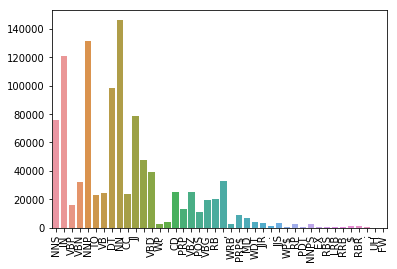

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()


### 7. Dataloader & Evaluate Model

Check whether it works before training!

In [60]:
def dataloader(npoints, X_, y_):
    """Function to load the data"""
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #subset the data
        to_ret.append((name, lang, word_rep(name), tag_rep(lang)))
    
    return to_ret

In [61]:
#loading dataloader
dataloader(2, X_train, y_train)

[('Benshoofin',
  'NNP',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 

In [62]:
def eval(net, n_points, topk, X_, y_, device = device):
    "Evaluation function"

    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0

    #iterate
    for name, language, name_ohe, lang_rep in data_:
        
        name_ohe = name_ohe.to(device)
        lang_rep = lang_rep.to(device)
        
        

        #get the output
        output = infer(net, name, device)
        val, indices = output.topk(topk) #get the top k values
        indices = indices.to(device) #convert to devices
        
        if lang_rep in indices:
            correct += 1

    accuracy = correct/n_points
    return accuracy

In [63]:
#test the evaluation function
eval(net, 1000, 1, X_test, y_test)

0.013

### 8. Batching pytorch

In [64]:
#create a batched name rep

def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [65]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [66]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = tags.index(lang)
    return rep

In [67]:
#create dataloader
def batched_dataloader(npoints, X_, y_, verbose=False, device = device):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [68]:
out_ = batched_name_rep(['Beau', 'Ivo'], 5)
print_char(out_)

B
I
e
v
a
o
u
<pad>
<pad>
<pad>


In [69]:
batched_dataloader(2, X_train, y_train, True)

torch.Size([7, 2, 57]) torch.Size([9, 57])
--
['to', 'billion']
t
b
o
i
<pad>
l
<pad>
l
<pad>
i
<pad>
o
<pad>
n
--
b
t
i
o
l
l
i
o
n
Lang Rep tensor([18, 32], device='cuda:1')
Batch sizes tensor([2, 2, 1, 1, 1, 1, 1])


(PackedSequence(data=tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

### 9. Training
#### 9.1 Define train function

In [79]:
#basic train function

def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [80]:
def train_batch(net, opt, criterion, n_points, device = device):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    batch_input = batch_input.to(device)
    batch_groundtruth = batch_groundtruth.to(device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

#### 9.2 Define loss and optimizer

In [81]:
net = RNN_net(n_letters, n_hidden, n_tags) #.to(device)
criterion = nn.NLLLoss().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

#### 9.3 Actual training

In [82]:
%%time 
#time for normal training
train(net, opt, criterion, 256)

CPU times: user 4.92 s, sys: 368 ms, total: 5.29 s
Wall time: 1.28 s


tensor(3.6930, grad_fn=<DivBackward0>)

### 10. Full training setup

In [83]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1 Accuracy:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2 Accuracy:', eval(net, len(X_test), 2, X_test, y_test, device))

Iteration 2999 Loss 0.3721696436405182


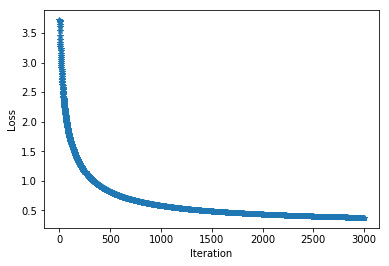




Top-1 Accuracy: 0.917979162196314 Top-2 Accuracy: 0.9770784159454498
CPU times: user 55min 8s, sys: 1min, total: 56min 8s
Wall time: 10min 17s


In [84]:
%%time

#training RNN using batch technique
net = RNN_net(n_letters, 128, n_tags)
train_setup(net, lr=0.15, n_batches=3200, batch_size = 512, display_freq=500)

### What I have learnt

One interesting point that I got from this lab is that training in batches is possible despite its difficulty. In order to do so, padding is required, since words come in different length. Traning in batches enables the model to be trained on the GPU which boosts the speed of the traning. 